# Multiclass logistic regression

https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html

In [1]:
import gzip
import array
import struct
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_int32(fin):
    buf = fin.read(4)
    return struct.unpack('>i', buf)[0]

def read_byte(fin):
    buf = fin.read(1)
    return struct.unpack('B', buf)[0]

def read_images(fin):
    magic = read_int32(fin)
    assert magic == 0x00000803, "magic number != 0x%08x" % magic
    num_images = read_int32(fin)
    num_rows = read_int32(fin)
    num_cols = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_images * num_rows * num_cols)
    return np.array(data).reshape((num_images, num_rows, num_cols))

def read_labels(fin):
    magic = read_int32(fin)
    assert magic == 0x00000801, "magic number != 0x%08x" % magic
    num_labels = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_labels)
    return np.array(data)

In [3]:
with gzip.open('data/3/train-images-idx3-ubyte.gz') as fin:
    train_images = read_images(fin)

with gzip.open('data/3/train-labels-idx1-ubyte.gz') as fin:
    train_labels = read_labels(fin)

with gzip.open('data/3/t10k-images-idx3-ubyte.gz') as fin:
    test_images = read_images(fin)

with gzip.open('data/3/t10k-labels-idx1-ubyte.gz') as fin:
    test_labels = read_labels(fin)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
def show_image(img):
    img = np.tile(img[:, :, np.newaxis], (1, 1, 3))
    plt.imshow(img, )

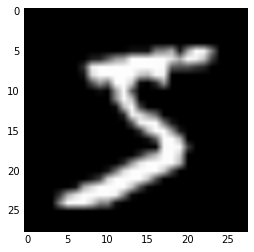

In [5]:
show_image(train_images[0])

In [6]:
train_labels[0]

5

In [7]:
num_examples, num_rows, num_cols = train_images.shape
num_tests, _, _ = test_images.shape
num_inputs = num_rows * num_cols
num_outputs = 10

In [8]:
train_inputs = train_images.reshape(num_examples, num_inputs)
test_inputs = test_images.reshape(num_tests, num_inputs)

In [9]:
train_inputs.shape, train_inputs.shape

((60000, 784), (60000, 784))

In [10]:
from common import transform_to_one_hot

In [11]:
train_outputs = transform_to_one_hot(train_labels, num_outputs)
test_outputs = transform_to_one_hot(test_labels, num_outputs)

In [12]:
train_outputs.shape, test_outputs.shape

((60000, 10), (10000, 10))

In [13]:
from common import split_data
batch_size = 64
train_data = split_data(train_inputs, train_outputs, batch_size)
test_data = split_data(test_inputs, test_outputs, batch_size)

In [14]:
W = np.random.randn(num_inputs, num_outputs)
b = np.random.randn(num_outputs)

$$softmax(z) = \frac{\exp(z)}{\sum_{i = 1}^{k} \exp(z_i)}$$
$$\hat{y} = softmax(xW + b)$$
$$\min_{W, b} - \sum_{j} {y_j \cdot \log{(\hat{y}_j + 10^{-6})}}$$

In [15]:
# yhat, y: (num_examples, num_outputs)
# return: (num_examples,)
def cross_entropy(yhat, y):
    return - np.sum(y * np.log(yhat+1e-6), axis=1)

In [16]:
# yhat, y: (num_examples, num_outputs)
# return: (num_examples, num_outputs)
def grad_cross_entropy(yhat, y):
    # D(y * log(yhat + 1e-6)) / dyhat
    # = y / (yhat + 1e-6)
    return - y / (yhat + 1e-6)

In [17]:
def rand_prob_dist(example_count, choice_count):
    yhat = np.random.uniform(size=(example_count, choice_count))
    yhat = yhat / np.sum(yhat, axis=1)[:, np.newaxis]
    return yhat

def rand_one_hot(example_count, choice_count):
    r = np.random.uniform(size=(example_count, choice_count))
    a = np.argmax(r, axis=1)
    y = np.zeros((example_count, num_outputs))
    y[np.arange(a.size), a] = 1
    return y

In [18]:
def calc_numeric_grad(func, x, delta=1e-3):
    y = func(x)
    input_size = 1 if np.isscalar(x) else x.size
    output_size = 1 if np.isscalar(y) else y.size
    delta_mat = np.identity(input_size) * delta
    grad = np.zeros((output_size, input_size))
    for i in range(input_size):
        h = delta_mat[i]
        y_ = func(x + h)
        g = (y_ - y) / delta
        grad[:, i] = g
    return grad

In [30]:
def test_grad_cross_entropy(delta=1e-4):
    yhat = rand_prob_dist(1, num_outputs)
#     y = rand_one_hot(1, num_outputs)
    y = np.ones(num_outputs)
    grad1 = calc_numeric_grad(lambda x: cross_entropy(x, y), yhat)
    grad2 = grad_cross_entropy(yhat, y)
    print("numeric", grad1)
    print("grad", grad2)
    print("diff", grad1 - grad2)

test_grad_cross_entropy()

numeric [[ -6.62026655 -12.76401567  -9.44336235 -10.55828606 -12.63820538
   -9.7151693  -56.58704359 -10.12429334  -7.36823374  -7.10349522]]
grad [[ -6.64222895 -12.84582342  -9.48809159 -10.61422145 -12.718405
   -9.76251475 -58.21872195 -10.1757174   -7.39544597  -7.12878488]]
diff [[ 0.0219624   0.08180774  0.04472923  0.05593539  0.08019962  0.04734546
   1.63167836  0.05142406  0.02721223  0.02528967]]


In [20]:
# z: (num_examples, num_outputs)
# return: (num_examples, num_outputs)
def softmax(z):
    z_min = np.min(z, axis=1)
    z = z - z_min[:, np.newaxis]
    exp = np.exp(z)
    sum_exp = np.sum(exp, axis=1)[:, np.newaxis]
    return exp / sum_exp

In [21]:
z = np.random.randn(3, 4)
np.min(z, axis=1)

array([-1.02992638, -0.91711501,  0.41016197])

In [22]:
# z: (num_examples, num_outputs)
# return: (num_examples, num_outputs, num_outputs)
def grad_softmax(z):
    # D(softmax) / dz
    # = D(exp(z) * sum(exp(z))^-1) / dz
    # = D(exp(z)) / dz * sum(exp(z))^-1 + exp(z) * D(sum(exp(z))^-1) / dz
    # = exp(z) * sum(exp(z))^-1 + exp(z) * -1 * sum(exp(z))^-2 * exp(z)
    # = exp(z) / sum(exp(z)) - exp(z)^2 / sum(exp(z))^2
    z_min = np.min(z, axis=1)
    z = z - z_min[:, np.newaxis]
    exp = np.exp(z)
    sum_exp = np.sum(exp, axis=1)
#     print("sum_exp", sum_exp)
#     print("exp", exp)
    outer_mat = np.einsum("ij,ik->ijk", exp, exp)
    outer_mat /= sum_exp[:, np.newaxis, np.newaxis]**2
#     outer_mat = np.outer(exp, exp) / sum_exp**2
#     print("outer", outer_mat)
    diag = exp / sum_exp[:, np.newaxis]
#     print("diag", diag[0])
    diag_mat = np.zeros((diag.shape[0], diag.shape[1], diag.shape[1]))
    diag_idx = np.arange(diag.shape[1])
    diag_mat[:, diag_idx, diag_idx] = diag
#     print("diag", diag_mat)
    return diag_mat - outer_mat

In [29]:
def test_grad_softmax(delta=1e-3):
    z = np.random.randn(2, 3)
    h = rand_one_hot(1, num_outputs) * delta
    grad1 = np.array([calc_numeric_grad(softmax, r[np.newaxis, :]) for r in z])
    grad2 = grad_softmax(z)
    print("numeric", grad1)
    print("grad", grad2)
    print("diff", grad1 - grad2)

test_grad_softmax()

numeric [[[ 0.13892032 -0.10566489 -0.03320494]
  [-0.1057143   0.23197015 -0.12636022]
  [-0.03320602 -0.12630526  0.15956516]]

 [[ 0.2188655  -0.17807344 -0.04075965]
  [-0.1781139   0.24742838 -0.06938439]
  [-0.0407516  -0.06935493  0.11014405]]]
grad [[[ 0.13887402 -0.10567907 -0.03319495]
  [-0.10567907  0.23200129 -0.12632222]
  [-0.03319495 -0.12632222  0.15951717]]

 [[ 0.21882688 -0.17808247 -0.04074441]
  [-0.17808247  0.24744092 -0.06935845]
  [-0.04074441 -0.06935845  0.11010286]]]
diff [[[  4.62982948e-05   1.41847291e-05  -9.98539898e-06]
  [ -3.52316487e-05  -3.11402763e-05  -3.79990833e-05]
  [ -1.10666462e-05   1.69555471e-05   4.79844823e-05]]

 [[  3.86244615e-05   9.02310908e-06  -1.52418650e-05]
  [ -3.14327907e-05  -1.25373733e-05  -2.59459425e-05]
  [ -7.19167084e-06   3.51426423e-06   4.11878075e-05]]]


In [24]:
def gradient(W, b, x, y):
    pass

In [25]:
epochs = 100
learning_rate = .001

In [26]:
# for e in range(epochs):
#     cumulative_lld = 0
#     for bx, by in train_data:
#         yhat = logistic_regression(w, b, bx)
#         lld = log_likelihood(yhat, by)
#         cumulative_lld += lld
#         sgd_update(w, b, bx, by, learning_rate)
# #         print(w, b)
#     print(cumulative_lld)